## Network in network on CIFAR-10

This notebook demonstrates a "network in network" type NN as presented in

[Lin, M., Chen, Q., & Yan, S. (2013). Network in network. arXiv preprint arXiv:1312.4400.](https://arxiv.org/abs/1312.4400)

using Keras.

The network structure was mostly copied from https://gist.github.com/mavenlin/e56253735ef32c3c296d (which corresponds with the paper), though not all preprocessing, regularization, or optimizer settings are the same. As a result of these differences, the performance of this network is somewhat worse than what is presented in the paper.

Note: I haven't actually run this to completion as my GPU doesn't have enough memory and it's about 20 minutes an epoch on my CPU.


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import backend as K

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = (32,32,3)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(x_train.shape)

(50000, 32, 32, 3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
mlpconv_1_conv5x5 (Conv2D)   (None, 32, 32, 192)       14592     
_________________________________________________________________
mlpconv_1_conv1x1_1 (Conv2D) (None, 32, 32, 160)       30880     
_________________________________________________________________
mlpconv_1_conv1x1_2 (Conv2D) (None, 32, 32, 96)        15456     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 16, 16, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
mlpconv_2_conv5x5 (Conv2D)   (None, 16, 16, 192)       460992    
__________

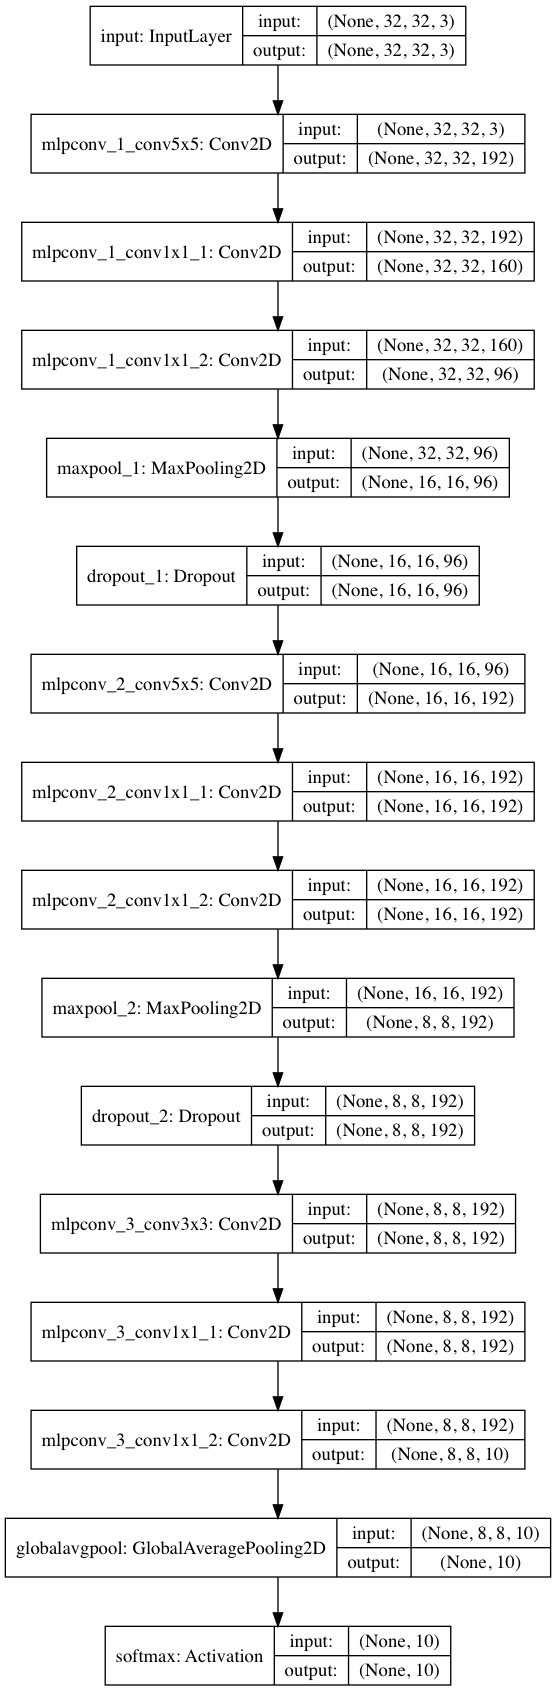

In [4]:
def nin(input_shape):
    inputs = layers.Input(shape = input_shape, name='input')
    
    x = layers.Conv2D(192, kernel_size=(5,5), padding = 'same', activation='relu', name='mlpconv_1_conv5x5')(inputs)
    x = layers.Conv2D(160, kernel_size=(1,1), padding = 'same', activation='relu', name='mlpconv_1_conv1x1_1')(x)
    x = layers.Conv2D(96, kernel_size=(1,1), padding = 'same', name='mlpconv_1_conv1x1_2')(x)
    x = layers.MaxPool2D(name='maxpool_1')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    
    x = layers.Conv2D(192, kernel_size=(5,5), padding = 'same', activation='relu', name='mlpconv_2_conv5x5')(x)
    x = layers.Conv2D(192, kernel_size=(1,1), padding = 'same', activation='relu', name='mlpconv_2_conv1x1_1')(x)
    x = layers.Conv2D(192, kernel_size=(1,1), padding = 'same', activation='relu', name='mlpconv_2_conv1x1_2')(x)
    x = layers.MaxPool2D(name='maxpool_2')(x)
    x = layers.Dropout(0.5, name='dropout_2')(x)
    
    x = layers.Conv2D(192, kernel_size=(3,3), padding = 'same', activation='relu', name='mlpconv_3_conv3x3')(x)
    x = layers.Conv2D(192, kernel_size=(1,1), padding = 'same', activation='relu', name='mlpconv_3_conv1x1_1')(x)
    x = layers.Conv2D(10, kernel_size=(1,1), padding = 'same', activation='relu', name='mlpconv_3_conv1x1_2')(x)
    x = layers.GlobalAveragePooling2D(name='globalavgpool')(x)
    
    predictions = layers.Activation('softmax', name='softmax')(x)
    
    model = Model(inputs = inputs, outputs = predictions)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer = optimizers.adadelta(),
                metrics=['accuracy'])
    return model

nin_model = nin(input_shape)

Image(model_to_dot(nin_model, show_shapes = True).create_png(prog='dot'))

<IPython.core.display.Javascript object>


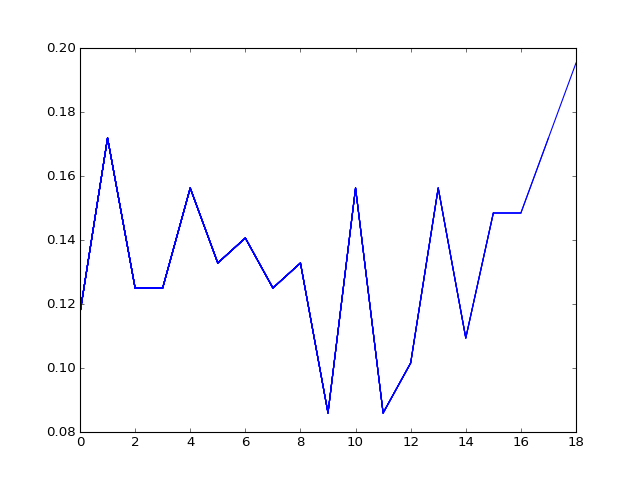

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 2432/50000 [>.............................] - ETA: 1096s - loss: 2.2739 - acc: 0.1361

KeyboardInterrupt: 

In [7]:
def plot_progress(statistic='acc'):
    fig = plt.figure()
    plt.ion()

    fig.show()
    ax = fig.add_subplot(111)
    fig.canvas.draw()
 
    data = []
    
    def plot_progress_helper(i, logs):
        ax.set_prop_cycle(None)
        data.append(logs[statistic])
        ax.plot(data)
        fig.canvas.draw()
    
    return plot_progress_helper

history = nin_model.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 50,
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks = [
        keras.callbacks.LambdaCallback(on_epoch_end=plot_progress())
    ]
)

score = nin_model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])